### TODO:
* Downloading a text dataset https://arxiv.org/pdf/1710.06071
* **Preprocessing** text data
* Setting up multiple modelling experiments with **different levels of embeddings**
* Building a **multimodal model** to take in different sources of data
  * **Replicating** the model powering https://arxiv.org/abs/1612.05251
* Finding the most wrong prediction examples

```
Input: A piece of text -> Model -> Output: the label that the input might belong to (Multiclass classification)
```

In [1]:
!nvidia-smi

Sat Aug 24 04:13:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### Download data from author github

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25 (from 1)
Receiving objects: 100% (39/39), 177.08 MiB | 19.14 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


### Becoming one with data

Always start with small dataset (10% of the total data) before scaling up

In [3]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [4]:
data_10_percent_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [19]:
import os
import tensorflow as tf
# tf.random.set_seed(1)

filenames = [data_10_percent_dir + filename for filename in os.listdir(data_10_percent_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

#### Preprocess

* Write a function to read in all of the lines in a target file

In [6]:
def get_lines(filepath):
  """
  Reads filepath and returns the lines of text as a list

  Args:
    filepath: a string representing the target file

  Returns:
    A list of string
  """
  with open(filepath, "r") as f:
    return f.readlines()

In [7]:
train_data = get_lines(filenames[0])
# dev_data = get_lines(filenames[0])
# data = train_data + dev_data

In [8]:
train_data

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

**Note:** Always represent data into a list of dictionary

Example:
```
[
  {
    "line_number": 0,
    "target": "BACKGROUND",
    "text": "Hello world",
    "total_lines": 11
  }
]
```

* Preprocessing function

In [11]:
def preprocess_text_with_line_numbers(filepath):
  """
  Returns a list of dictionaries of abstract line data.

  Takes in filename, reads it contents and sorts through each line, extracting things like the target label,
  the text of the sentence, how many sentences are in the current abstract and what sentence number the target line is.
  """
  print(filepath)
  input_lines = get_lines(filepath) # Get all lines from filename
  abstract_lines = ""
  abstract_samples = [] # Create an empty list of abstracts

  # Loop through each line
  for i in input_lines:

    if i.startswith("###"):
      abstract_id = i
      abstract_lines = ""

    elif i.isspace(): # check if a line is a new abstract
      abstract_line_split = abstract_lines.splitlines()

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t") # split target from text, because the target is separate from text by \t
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1].lower()
        line_data["line_number"] = abstract_line_number
        line_data["total_line"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)

    else: # If the above conditions aren't fulfilled, the line contains a labelled sentence
        abstract_lines += i

  return abstract_samples

In [20]:
%%time
train_samples = preprocess_text_with_line_numbers(filenames[0])
test_samples = preprocess_text_with_line_numbers(filenames[1])
val_samples = preprocess_text_with_line_numbers(filenames[2]) # dev is another name for validation dataset

pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt
pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt
CPU times: user 674 ms, sys: 119 ms, total: 794 ms
Wall time: 894 ms


In [21]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

#### Visualize

Turn data into pandas DataFrame for visualization

In [22]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [23]:
len(train_df), len(val_df), len(test_df)

(180040, 30212, 30135)

In [24]:
train_df.head(10)

,target,text,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [25]:
# Check the distribution of labels in training data
train_df.target.value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

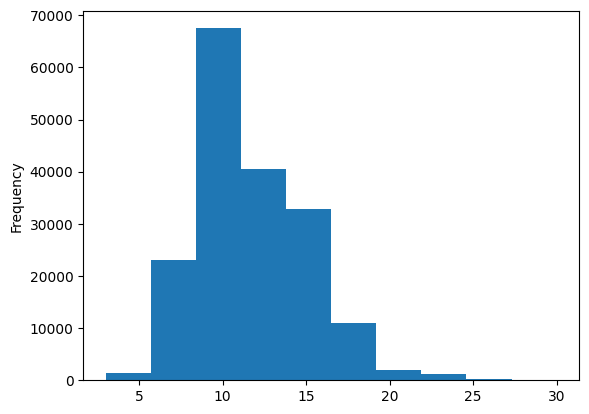

In [26]:
# Check the length of different lines
train_df.total_line.plot.hist()

####  Get lists of sentences

In [28]:
train_sentences = train_df.text.tolist()
val_sentences = val_df.text.tolist()
test_sentences = test_df.text.tolist()

In [29]:
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

#### Turn labels into numeric form

In [30]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1)) # Only use transform because it will ensure the outputs of val_df is the same as train_df\
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [31]:
len(train_labels_one_hot), len(val_labels_one_hot), len(test_labels_one_hot)

(180040, 30212, 30135)

#### Label encode labels

In [32]:
# Extract labels ("target" columns) and encoder them into integer
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.fit_transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.fit_transform(test_df['target'].to_numpy())


In [35]:
len(train_labels_encoded), len(val_labels_encoded), len(test_labels_encoded)

(180040, 30212, 30135)

In [34]:
# Map numeric version with text version
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
class_names, num_classes

(array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object),
 5)

### Start experiments

#### Download helper functions

In [36]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-08-24 04:21:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-08-24 04:21:23 (88.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [37]:
from helper_functions import *

#### Model 0: Base line (TF-IDF, Multinomial Naive Bayes Classifier)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf", TfidfVectorizer()),
    ("clf", MultinomialNB())
])

model_0.fit(X = train_sentences,
            y = train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [39]:
# Evaluate baseline
baseline_eval = model_0.score(val_sentences, val_labels_encoded)

In [40]:
baseline_eval

0.7218323844829869

In [41]:
# Make predictions using our baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds, val_labels_encoded

(array([4, 1, 3, ..., 4, 4, 1]), array([0, 0, 3, ..., 4, 1, 1]))

In [42]:
baseline_results = calculate_results(val_labels_encoded, baseline_preds)

In [43]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#### Prepare Tokenization + Embedding for deep sequence model

In [44]:
import numpy as np
import tensorflow as tf
import tf_keras
from tensorflow.keras import layers

In [45]:
# How long is each sentence on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

26.338269273494777

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

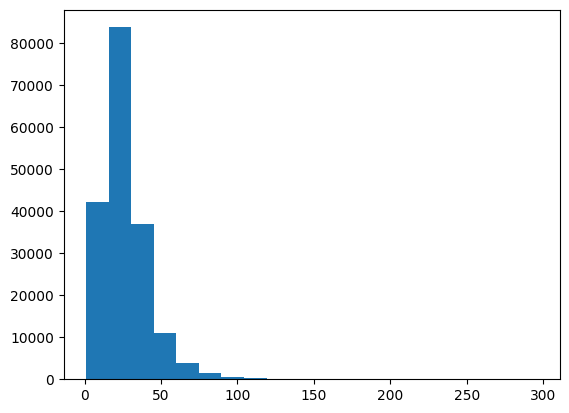

In [46]:
# Check the distribution of sentence length
import matplotlib.pyplot as plt

plt.hist(sent_lens, bins=20)

**Percentile:** When we talk about percentile, we talk about these two things:
  * How many data that is **below** the total amount of data.
  * How many data that is **at or below** the total amount of data.

In [47]:
# Check how long of a sentence covers 95% of examples. Because we want to take a sequence length value that
# cover the vast majority of our total data (95%).
output_seg_len = int(np.percentile(sent_lens, 95))
output_seg_len

55

In [48]:
# Maximum sequence length in the training set
max(sent_lens)

296

Create Text vectorizer

* Max vocabulary size: Only the N most common text that can be vectorized. According to the paper, **the vocab size for PubMed 20K** is 68K

In [49]:
max_vocabulary_len = 68000

text_vectorizer = layers.TextVectorization(
    max_tokens = max_vocabulary_len,
    output_sequence_length = output_seg_len,
    # standardize = "lower_and_strip_punctuation",
    # output_mode = "int",
    # pad_to_max_tokens = True,
)

In [50]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [51]:
#Test our text vectorizer on random sentences
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n {target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text: {text_vectorizer([target_sentence])}")

Text:
 the oswestry disability index scores for the treatment of compression fractures without a brace were not inferior to those with soft or rigid braces .

Length of text: 150

Vectorized text: [[   2 3807  612  203  119   11    2   19    4 1849 1285  159    8 4501
     9   31 1592    6  125    7 2484   16 4224 7926    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]


In [52]:
# Get the words in our vocabulary
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [53]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

Creating a custom embedding

In [54]:
embedding = layers.Embedding(
    input_dim = len(rct_20k_text_vocab), # input dim should be equal to the vocabulary len
    output_dim = 128, # The larger this value, the more parameter the model need to train
    mask_zero = True, # Hide all padding value
)

In [55]:
# Show an example embedding

print(f"Sentence before vectorization:\n {target_sentence}\n")
print(f"Sentence after vectorization (before embedding):\n {text_vectorizer([target_sentence])}\n")
print(f"Sentence after embedding:\n {embedding(text_vectorizer([target_sentence]))}")
print(f"Embedded sentence shape:\n {embedding(text_vectorizer([target_sentence])).shape}")


Sentence before vectorization:
 the oswestry disability index scores for the treatment of compression fractures without a brace were not inferior to those with soft or rigid braces .

Sentence after vectorization (before embedding):
 [[   2 3807  612  203  119   11    2   19    4 1849 1285  159    8 4501
     9   31 1592    6  125    7 2484   16 4224 7926    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0]]

Sentence after embedding:
 [[[-0.01239499 -0.01039974  0.02463516 ...  0.0495437  -0.00730645
   -0.03878714]
  [-0.03771482 -0.01979331  0.00415421 ...  0.04259228 -0.03784847
    0.02097325]
  [ 0.01773217  0.00668768 -0.01695174 ...  0.02872724 -0.03702907
   -0.043308  ]
  ...
  [-0.04743453  0.02720323 -0.02280461 ...  0.0145072  -0.03709414
   -0.00112657]
  [-0.04743453  0.02720323 -0.02280461 ...  0.0145072  -0.03709414
   -0.00112657]
  [-0.04743453  0.02720323 -0.02

#### Create fast loading dataset with tf.data API

https://www.tensorflow.org/guide/data_performance \
https://www.tensorflow.org/guide/data

* **Prefetching**: To avoid synchronous training for example the model is sitting idle when waiting for opening data and otherwise. Prefetching **overlaps the preprocessing and model execution** of a training step. While the model is executing training step s, the input pipeline is reading the data for step s+1.

* Best practices: using **prefetching with multithread loading**. This will reduce the prepare data step => faster the training step

In [56]:
# Making sure our data loads as fast as possible

In [57]:
train_dataset = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_labels_one_hot)
)

valid_dataset = tf.data.Dataset.from_tensor_slices(
    (val_sentences, val_labels_one_hot)
)

test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_labels_one_hot)
)

In [58]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTONE means prefetch as many samples as possible at a time
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [59]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [60]:
from tensorflow.keras import mixed_precision

tf.random.set_seed(42)
mixed_precision.set_global_policy('mixed_float16')

#### Model 1: Conv1D with token embeddings

In [61]:
inputs = layers.Input(shape=(1,), dtype=tf.string)

# get vectorizer
text_tokenization = text_vectorizer(inputs)

# embedding
embed = embedding(text_tokenization)

# Conv1D layer
x = layers.Conv1D(
    filters = 64,
    kernel_size = 3,
    strides = 1, # has the effect on reducing overfitting
    padding = 'valid',
    activation = 'relu'
)(embed)

# x = layers.Conv1D(
#     filters = 64,
#     kernel_size = 3,
#     strides = 1,
#     padding = 'valid',
#     activation = 'relu'
# )(x)

# Pooling layer (Global average)
x = layers.GlobalAveragePooling1D()(x)

# Dense layer
print(len(class_names))
outputs = layers.Dense(len(class_names), activation="softmax")(x)

# Model
model_1 = tf.keras.Model(inputs, outputs)

# Compile model
model_1.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

5


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [62]:
model_1.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization                   │ (None, 55)                  │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 55, 128)             │       8,299,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 53, 64)              │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 64)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,324,613 (31.76 MB)

 Trainable params: 8,324,613 (31.76 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
model_1_history = model_1.fit(
    train_dataset, epochs = 3, validation_data = valid_dataset,
    callbacks=[create_tensorboard_callback("Experiments", "Conv1D_with_token_embedding")]
)

Saving TensorBoard log files to: Experiments/Conv1D_with_token_embedding/20240824-043424
Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 81s 14ms/step - accuracy: 0.8196 - loss: 0.5153 - val_accuracy: 0.8113 - val_loss: 0.5313
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 75s 13ms/step - accuracy: 0.8538 - loss: 0.4229 - val_accuracy: 0.8103 - val_loss: 0.5320
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 84s 14ms/step - accuracy: 0.8796 - loss: 0.3553 - val_accuracy: 0.8075 - val_loss: 0.5597


In [65]:
# Make predictions using our baseline model
model_1_pred_probs = model_1.predict(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [66]:
model_1_pred_probs

array([[7.9248e-01, 7.2632e-03, 1.0724e-01, 6.1188e-02, 3.1860e-02],
       [6.0352e-01, 7.6599e-02, 6.2904e-03, 2.9395e-01, 1.9562e-02],
       [2.6440e-01, 6.2027e-03, 1.5326e-03, 7.2803e-01, 7.2241e-05],
       ...,
       [6.5565e-07, 2.5272e-05, 6.8521e-04, 1.4305e-06, 9.9951e-01],
       [2.3895e-02, 3.8062e-01, 4.3140e-01, 7.9575e-03, 1.5613e-01],
       [5.3406e-03, 9.9316e-01, 1.1406e-03, 1.2100e-05, 1.3673e-04]],
      dtype=float16)

In [67]:
len(model_1_pred_probs)

30212

In [68]:
model_1_pred = tf.argmax(model_1_pred_probs, axis = 1) # 0 to find max across column and 1 for row
model_1_pred

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [69]:
len(val_labels_encoded)

30212

In [70]:
model_1_results = calculate_results(val_labels_encoded, model_1_pred)
model_1_results

{'accuracy': 80.74606116774791,
 'precision': 0.8042375078158095,
 'recall': 0.8074606116774792,
 'f1': 0.8051438438726171}

#### Model 2: Feature extraction with pretrained token embeddings (USE)

In [71]:
import tensorflow_hub as hub

embedding_layer = hub.KerasLayer(
  "https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2",
  input_shape=[], # Set this to empty so that it can takes input of any variable length, however the output is always of length 512
  dtype=tf.string,
  trainable = False
)

In [72]:
import tf_keras

model_2 = tf_keras.Sequential([
    embedding_layer,
    tf_keras.layers.Dense(128, activation="relu"),
    tf_keras.layers.Dense(5, activation="softmax")
])

model_2.compile(
    loss = "categorical_crossentropy",
    optimizer = tf_keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [73]:
def create_tensorboard_callback_sequential(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.

  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"

  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf_keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [74]:
model_2_history = model_2.fit(
    train_dataset, epochs = 3, validation_data = valid_dataset,
    callbacks=[create_tensorboard_callback_sequential("Experiments", "Dense_with_pretrained_token_embedding")]
)

Saving TensorBoard log files to: Experiments/Dense_with_pretrained_token_embedding/20240824-044102
Epoch 1/3
5627/5627 [==============================] - 84s 13ms/step - loss: 0.7302 - accuracy: 0.7211 - val_loss: 0.6591 - val_accuracy: 0.7481
Epoch 2/3
5627/5627 [==============================] - 74s 13ms/step - loss: 0.6369 - accuracy: 0.7586 - val_loss: 0.6228 - val_accuracy: 0.7633
Epoch 3/3
5627/5627 [==============================] - 74s 13ms/step - loss: 0.6020 - accuracy: 0.7724 - val_loss: 0.6083 - val_accuracy: 0.7676


In [75]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred = tf.argmax(model_2_pred_probs, axis = 1) # 0 to find max across column and 1 for row

model_2_results = calculate_results(val_labels_encoded, model_2_pred)
model_2_results

945/945 [==============================] - 10s 10ms/step


{'accuracy': 76.76088971269695,
 'precision': 0.7657912824235106,
 'recall': 0.7676088971269694,
 'f1': 0.7634050664594734}

#### Model 3: Conv1D with character-level tokenizer

* Token vs character-level tokenization
  * For character-level, you have to convert your train sequence into character

In [76]:
# Make function to split sentences into characters

def split_chars(text):
  return " ".join(list(text))

# Text splitting word-level sequence into characters-level
train_chars = [split_chars(sentence) for sentence in train_sentences]
valid_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [77]:
# What's the average character length?
char_len = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_len)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

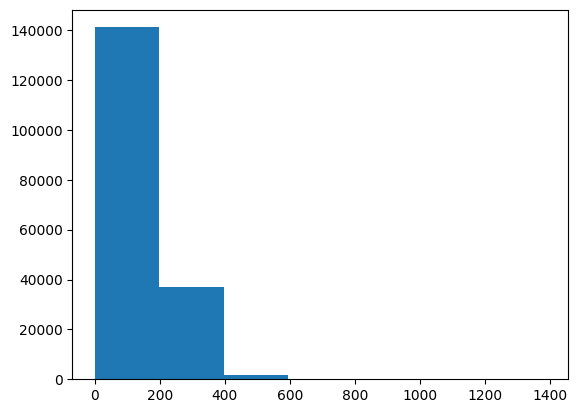

In [78]:
# Check the distribution of char len
import matplotlib.pyplot as plt
plt.hist(char_len, bins=7)

In [79]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_len, 95))
output_seq_char_len

290

* For character level the vocab size just take the length of all keyboard characters

In [80]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
max_vocab_character_size = len(alphabet)

In [81]:
char_vectorizer = layers.TextVectorization(
    max_tokens = max_vocab_character_size,
    output_sequence_length = output_seq_char_len,
    # standardize = "lower_and_strip_punctuation",
    # output_mode = "int",
    # pad_to_max_tokens = True,
)

In [82]:
# Adapt char vectorizer to training character
char_vectorizer.adapt(train_chars)

In [83]:
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'z', 'q', 'j']


In [84]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25, # This is the size of the char of embedding in paper (Figure 1)
    mask_zero = True
)

In [85]:
inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
char_vectorization = char_vectorizer(inputs)

char_embed = char_embedding(char_vectorization)

x = layers.Conv1D(
    filters = 128,
    kernel_size = 3,
    strides = 1, # has the effect on reducing overfitting
    padding = 'same',
    activation = 'relu'
)(char_embed)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_3.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'conv1d_1' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_vectorization_1                 │ (None, 290)                 │               0 │
│ (TextVectorization)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 290, 25)             │             700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 290, 128)            │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,073 (43.25 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
train_chars_dataset = tf.data.Dataset.from_tensor_slices(
    (train_chars, train_labels_one_hot)
)

valid_chars_dataset = tf.data.Dataset.from_tensor_slices(
    (valid_chars, val_labels_one_hot)
)

test_chars_dataset = tf.data.Dataset.from_tensor_slices(
    (test_chars, test_labels_one_hot)
)

In [87]:
train_chars_dataset = train_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # AUTONE means prefetch as many samples as possible at a time
valid_chars_dataset = valid_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_chars_dataset = test_chars_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
from tensorflow.keras import mixed_precision

tf.random.set_seed(42)
mixed_precision.set_global_policy('mixed_float16')

In [89]:
from helper_functions import create_tensorboard_callback

model_3_history = model_3.fit(
    train_chars_dataset, epochs = 3, validation_data = valid_chars_dataset,
    callbacks=[create_tensorboard_callback("Experiments", "Conv1D_with_character_level_embedding")]
)

Saving TensorBoard log files to: Experiments/Conv1D_with_character_level_embedding/20240824-044817
Epoch 1/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 49s 8ms/step - accuracy: 0.4212 - loss: 1.3528 - val_accuracy: 0.5026 - val_loss: 1.1983
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - accuracy: 0.5149 - loss: 1.1731 - val_accuracy: 0.5469 - val_loss: 1.0906
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - accuracy: 0.5691 - loss: 1.0663 - val_accuracy: 0.5867 - val_loss: 1.0206


In [90]:
model_3_pred_probs = model_3.predict(valid_chars_dataset)
model_3_pred = tf.argmax(model_3_pred_probs, axis=1)

model_3_results = calculate_results(val_labels_encoded, model_3_pred)
model_3_results

945/945 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


{'accuracy': 58.668740897656555,
 'precision': 0.5651642561577495,
 'recall': 0.5866874089765656,
 'f1': 0.5554293520739827}

#### Model 4: Pretrained token embeddings (same as 2) + character embeddings (same as 3) (hybrid embedding layer)

1. Create token-level embedding ( model 1 )
2. Create character-level embedding (model 3)
3. Combine 1 & 2 with a concatenate layer
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper
5. Construct a model which takes charater and token level sequences as input and produces sequence label probability

In [91]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
tf_hub_embedding = hub.KerasLayer(module_url,
                                  trainable=False,
                                  input_shape=[], # Set this to empty so that it can takes input of any variable length, however the output is always of length 512
                                  dtype=tf.string,)

In [92]:
class UniversalSetenceEncoder(tf.keras.Layer):
    def call(self, x):
        print(tf_hub_embedding(x))
        return tf_hub_embedding(x)

In [94]:
char_embedding = tf.keras.layers.Embedding(
    input_dim = len(char_vocab),
    output_dim = 25, # This is the size of the char of embedding in paper (Figure 1)
    mask_zero = False
)

In [95]:
# 1. Set up token/embedding
token_input = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embedding = UniversalSetenceEncoder(name="universal_sentence_encoding")(token_input)
token_output = layers.Dense(128, activation="relu")(token_embedding)
token_model = tf.keras.Model(
    token_input, token_output
)

# 2. Set up char input/model
char_input = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_input)
char_embed = char_embedding(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embed) # Bi-LSTM show in figure 1, GPU usually works best with multiple of 8
char_model = tf.keras.Model(char_input, char_bi_lstm)

# 3. Concat the two above model (create hybrid token embedding)
concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])

# 4. Create output layers + adding in Dropout
dropout = layers.Dropout(0.5)(concat)
dense = layers.Dense(128, activation="relu")(dropout)
final_dropout = layers.Dropout(0.1)(dense)
output = layers.Dense(num_classes, activation="softmax")(final_dropout)

# 5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input], outputs=output)

Tensor("keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)


In [103]:
model_4.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

model_4.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ char_input (InputLayer)   │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_input (InputLayer)  │ (None)                 │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 290)            │              0 │ char_input[0][0]       │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ universal_sentence_encod… │ (None, 512)            │              0 │ token_input[0][0]      │
│ (UniversalSetenceEncoder) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 290, 25)        │            700 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         65,664 │ universal_sentence_en… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 48)             │          9,600 │ embedding_2[0][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ dense_2[0][0],         │
│ (Concatenate)             │                        │                │ bidirectional[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 128)            │         22,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 128)            │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 5)              │            645 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 99,265 (387.75 KB)

 Trainable params: 99,265 (387.75 KB)

 Non-trainable params: 0 (0.00 B)

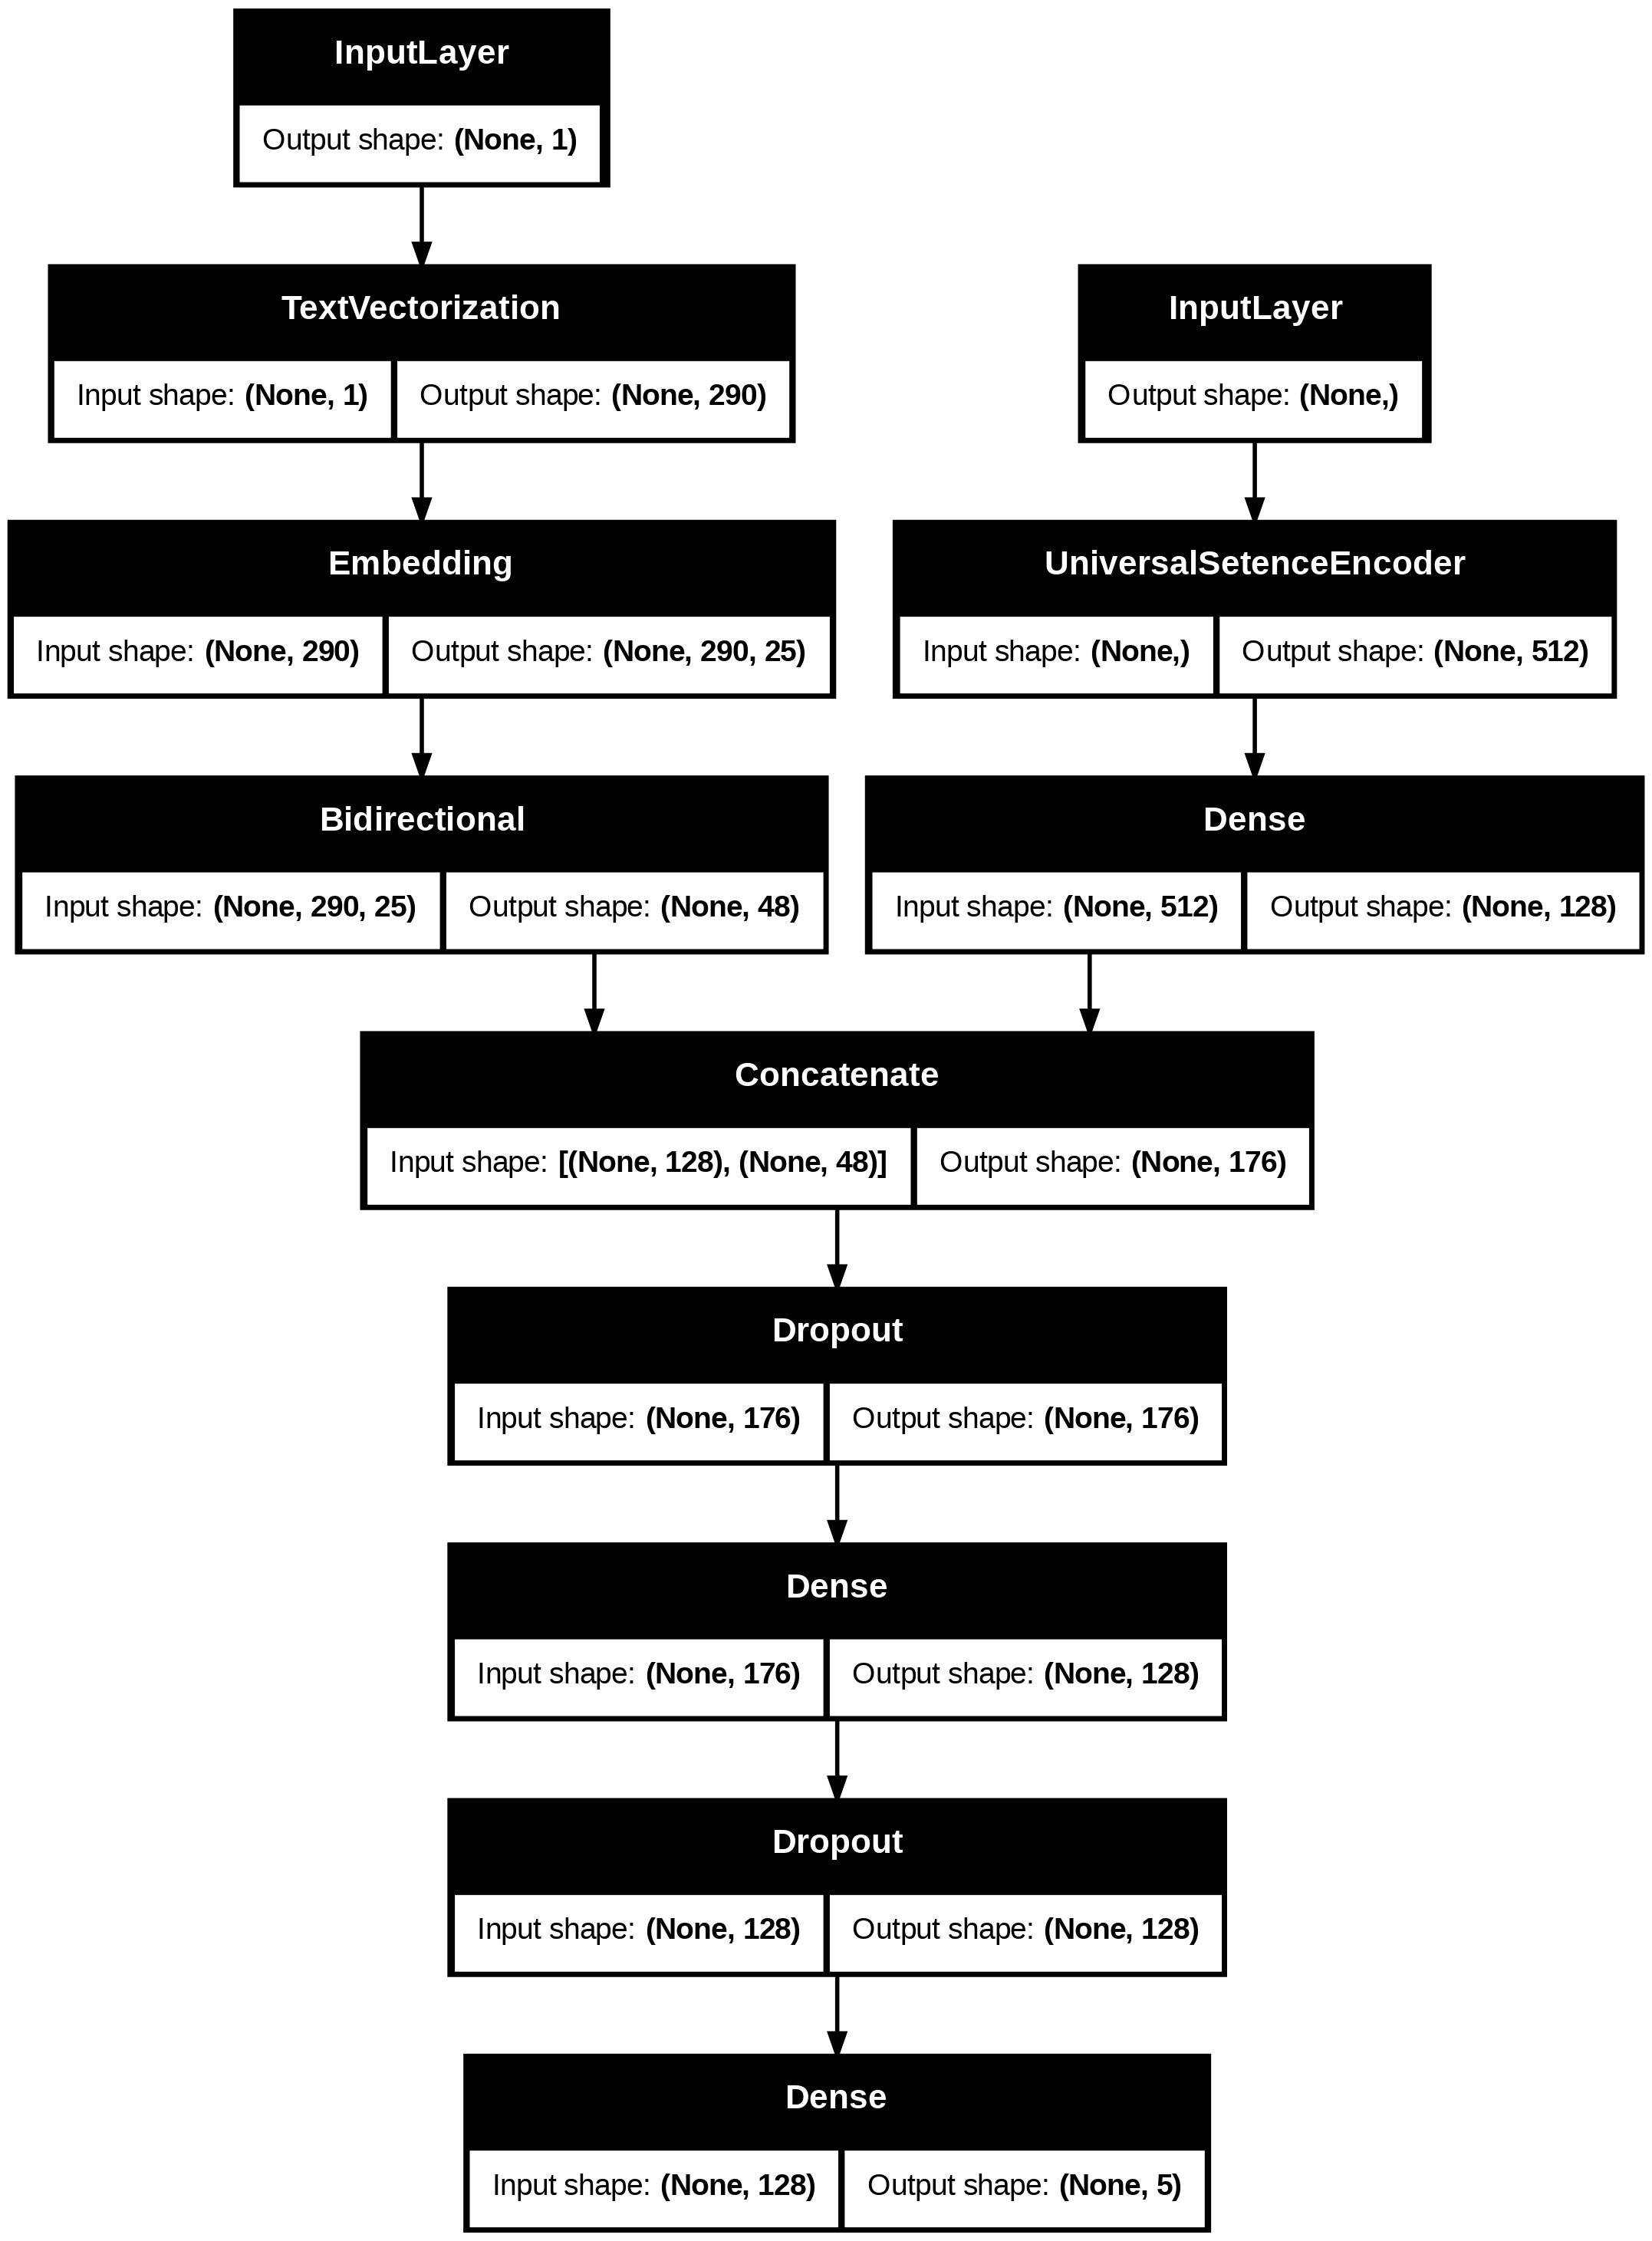

In [104]:
from keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [105]:
# Create efficient data pipepline
train_multiple_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars)
)
train_multiple_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_multiple_dataset = tf.data.Dataset.zip(train_multiple_data, train_multiple_labels) # Concatenate data and labels
train_multiple_dataset = train_multiple_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_multiple_data = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_chars)
)
test_multiple_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_multiple_dataset = tf.data.Dataset.zip(test_multiple_data, test_multiple_labels) # Concatenate data and labels
test_multiple_dataset = test_multiple_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_multiple_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, valid_chars)
)
val_multiple_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_multiple_dataset = tf.data.Dataset.zip(val_multiple_data, val_multiple_labels) # Concatenate data and labels
val_multiple_dataset = val_multiple_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


* **Note**: Remember the dataset order when creating data pipeline

In [106]:
train_multiple_dataset

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [107]:
model_4_history = model_4.fit(
    train_multiple_dataset, epochs = 3, validation_data = val_multiple_dataset,
    callbacks = [
        create_tensorboard_callback("Experiments", "Hybrid_model")
    ]
)

Saving TensorBoard log files to: Experiments/Hybrid_model/20240824-045450
Epoch 1/3
Tensor("functional_4_1/universal_sentence_encoding_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
Tensor("functional_4_1/universal_sentence_encoding_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6767 - loss: 0.8266Tensor("functional_4_1/universal_sentence_encoding_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 214s 37ms/step - accuracy: 0.6767 - loss: 0.8265 - val_accuracy: 0.7599 - val_loss: 0.6294
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 213s 38ms/step - accuracy: 0.7432 - loss: 0.6735 - val_accuracy: 0.7729 - val_loss: 0.6003
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 216s 38ms/step - accuracy: 0.7533 - loss: 0.6467 - val_accuracy: 0.7792 - val_loss: 0.5821


In [108]:
model_4_pred_probs = model_4.predict(val_multiple_dataset)
model_4_pred = tf.argmax(model_4_pred_probs, axis=1)

Tensor("functional_4_1/universal_sentence_encoding_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
942/945 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/stepTensor("functional_4_1/universal_sentence_encoding_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
945/945 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step


In [109]:
model_4_results = calculate_results(val_labels_encoded, model_4_pred)

In [110]:
baseline_results, model_1_results, model_2_results, model_3_results, model_4_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 80.74606116774791,
  'precision': 0.8042375078158095,
  'recall': 0.8074606116774792,
  'f1': 0.8051438438726171},
 {'accuracy': 76.76088971269695,
  'precision': 0.7657912824235106,
  'recall': 0.7676088971269694,
  'f1': 0.7634050664594734},
 {'accuracy': 58.668740897656555,
  'precision': 0.5651642561577495,
  'recall': 0.5866874089765656,
  'f1': 0.5554293520739827},
 {'accuracy': 77.92267972990865,
  'precision': 0.7761269654809109,
  'recall': 0.7792267972990865,
  'f1': 0.7752717289192708})

* Model 1 is our best model so far

#### Model 5: Pretrained token embeddings + Character embeddings + positional embeddings (Tribid embedding model)

* Feature Engineering
  * Taking **none-obvious** features from the data and encoding them numerically to help our model learn
  * How can we add extra sources of data to our model?

* Engineered features needd to be available at test time.  
* Data augmentation is a form of feature engineering

<Axes: ylabel='Frequency'>

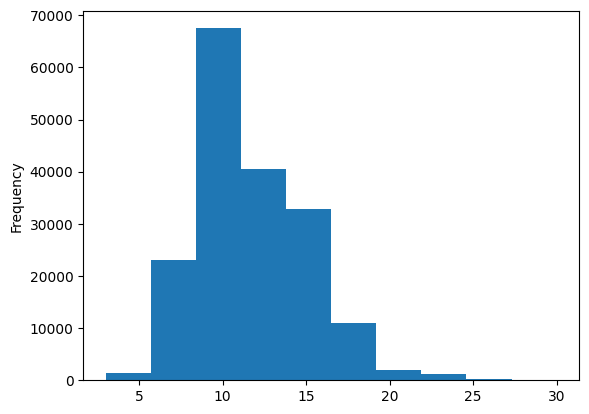

In [112]:
train_df.total_line.plot(kind="hist")

* one hot encode total_line feature

In [115]:
# Check the 95% percentile
np.percentile(train_df.total_line, 98)

20.0

In [120]:
# Use tensorflow onehot encoded on total_line feature
train_total_line_one_hot = tf.one_hot(train_df["total_line"].to_numpy(),
                                      depth = 20 # percentile
                                      )
valid_total_line_one_hot = tf.one_hot(val_df["total_line"].to_numpy(),
                                      depth = 20 # percentile
                                      )
test_total_line_one_hot = tf.one_hot(test_df["total_line"].to_numpy(),
                                      depth = 20 # percentile
                                      )

In [119]:
train_total_line_one_hot

<tf.Tensor: shape=(180040, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

* One hot encode "line_number" feature

<Axes: ylabel='Frequency'>

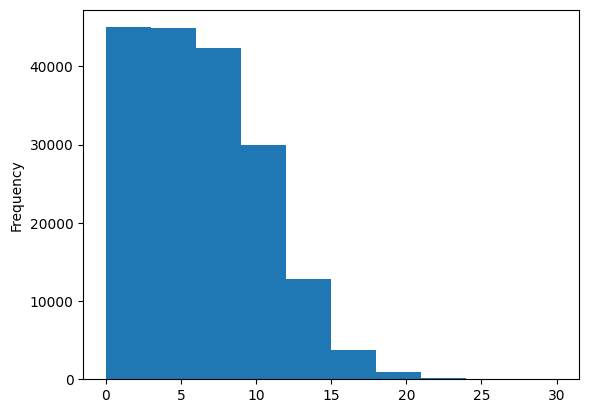

In [121]:
train_df.line_number.plot(kind="hist")

In [122]:
# Check the 95% percentile
np.percentile(train_df.line_number, 98)

15.0

In [123]:
# Use tensorflow onehot encoded on total_line feature
train_line_number_one_hot = tf.one_hot(train_df["line_number"].to_numpy(),
                                      depth = 15 # percentile
                                      )
valid_line_number_one_hot = tf.one_hot(val_df["line_number"].to_numpy(),
                                      depth = 15 # percentile
                                      )
test_line_number_one_hot = tf.one_hot(test_df["line_number"].to_numpy(),
                                      depth = 15 # percentile
                                      )

In [124]:
train_line_number_one_hot.shape

TensorShape([180040, 15])

* Steps in building a tribid embedding model

1. Create a token-level model
2. Create a character-level model
3. Create a model for the "line-number" feature
4. Create a model for the "total-line" feature
5. Combine the outputs of 1 & 2
6. Combine the outputs of 3, 4 & 5
7. Create an output layer to accept the tribrid embedding and output label probabilities
8. Combine the inputs of 1, 2, 3 & 4 and outputs into tf.keras.Model

In [138]:
# 1. Token inputs
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string, name="TokenInputLayer")
tokenized_inputs = UniversalSetenceEncoder(name="USEEncoder")(token_inputs)
token_outputs = tf.keras.layers.Dense(128, activation = "relu", name="TokenOutputLayer")(tokenized_inputs)
token_model = tf.keras.Model(token_inputs, token_outputs)

# 2. Char inputs
char_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name="CharInputLayer")
tokenized_char_inputs = char_vectorizer(char_inputs)
embed_tokenized_char_inputs = char_embedding(tokenized_char_inputs)
char_outputs = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(embed_tokenized_char_inputs)
char_model = tf.keras.Model(char_inputs, char_outputs)

# 3. "line-number" inputs
# inputs, shape = ?
# outputs dense layer with 32 units & relu activation
line_number_inputs = tf.keras.layers.Input(shape=(15,), dtype=tf.float32, name="LineNumberInputLayer")
line_number_outputs = tf.keras.layers.Dense(32, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, line_number_outputs)

# 4. "total-line" inputs
# inputs, shape = ?
# outputs dense layer with 32 units & relu activation
total_line_inputs = tf.keras.layers.Input(shape=(20,), dtype=tf.float32, name="TotalLineInputLayer")
total_line_outputs = tf.keras.layers.Dense(32, activation="relu")(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, total_line_outputs)

# 5. Hybrid embedding
combined_char_token = tf.keras.layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
z = layers.Dropout(0.5)(combined_char_token)
z = layers.Dense(128, activation="relu")(z)

# 6. Tribrid embedding
combined_all = tf.keras.layers.Concatenate(name="tribrid_embed")([line_number_model.output, total_line_model.output, z])
outputs = layers.Dense(num_classes, activation="softmax")(combined_all)

# 7, 8. Combine everything
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input, total_line_model.input], outputs=outputs)

Tensor("keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)


* **What is label smoothing**:

for example if our model gets too confident on a single class (e.g. its prediction probability is really high), it may get stuck on that cass and not consider other classes. This is called overfitting

Really confident: `[0.0, 0.0, 1.0, 0.0, 0.0]`

What label smoothing does is it assigns some of the values from the highest pred prob to other classes, in turn, hopefull improving generalization:
With label smoothing: `[0.01, 0.01, 0.96, 0.01, 0.01]`

**More about label smoothing:** https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [141]:
model_5.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

model_5.summary()

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ CharInputLayer            │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TokenInputLayer           │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ text_vectorization_1      │ (None, 290)            │              0 │ CharInputLayer[0][0]   │
│ (TextVectorization)       │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ USEEncoder                │ (None, 512)            │              0 │ TokenInputLayer[0][0]  │
│ (UniversalSetenceEncoder) │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 290, 25)        │            700 │ text_vectorization_1[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TokenOutputLayer (Dense)  │ (None, 128)            │         65,664 │ USEEncoder[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional_5           │ (None, 48)             │          9,600 │ embedding_2[5][0]      │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ token_char_hybrid         │ (None, 176)            │              0 │ TokenOutputLayer[0][0… │
│ (Concatenate)             │                        │                │ bidirectional_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ LineNumberInputLayer      │ (None, 15)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TotalLineInputLayer       │ (None, 20)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_9 (Dropout)       │ (None, 176)            │              0 │ token_char_hybrid[0][… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 32)             │            512 │ LineNumberInputLayer[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 32)             │            672 │ TotalLineInputLayer[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 128)            │         22,656 │ dropout_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ tribrid_embed             │ (None, 192)            │              0 │ dense_21[0][0],        │
│ (Concatenate)             │                        │                │ dense_22[0][0],        │
│                      

 Total params: 100,769 (393.63 KB)

 Trainable params: 100,769 (393.63 KB)

 Non-trainable params: 0 (0.00 B)

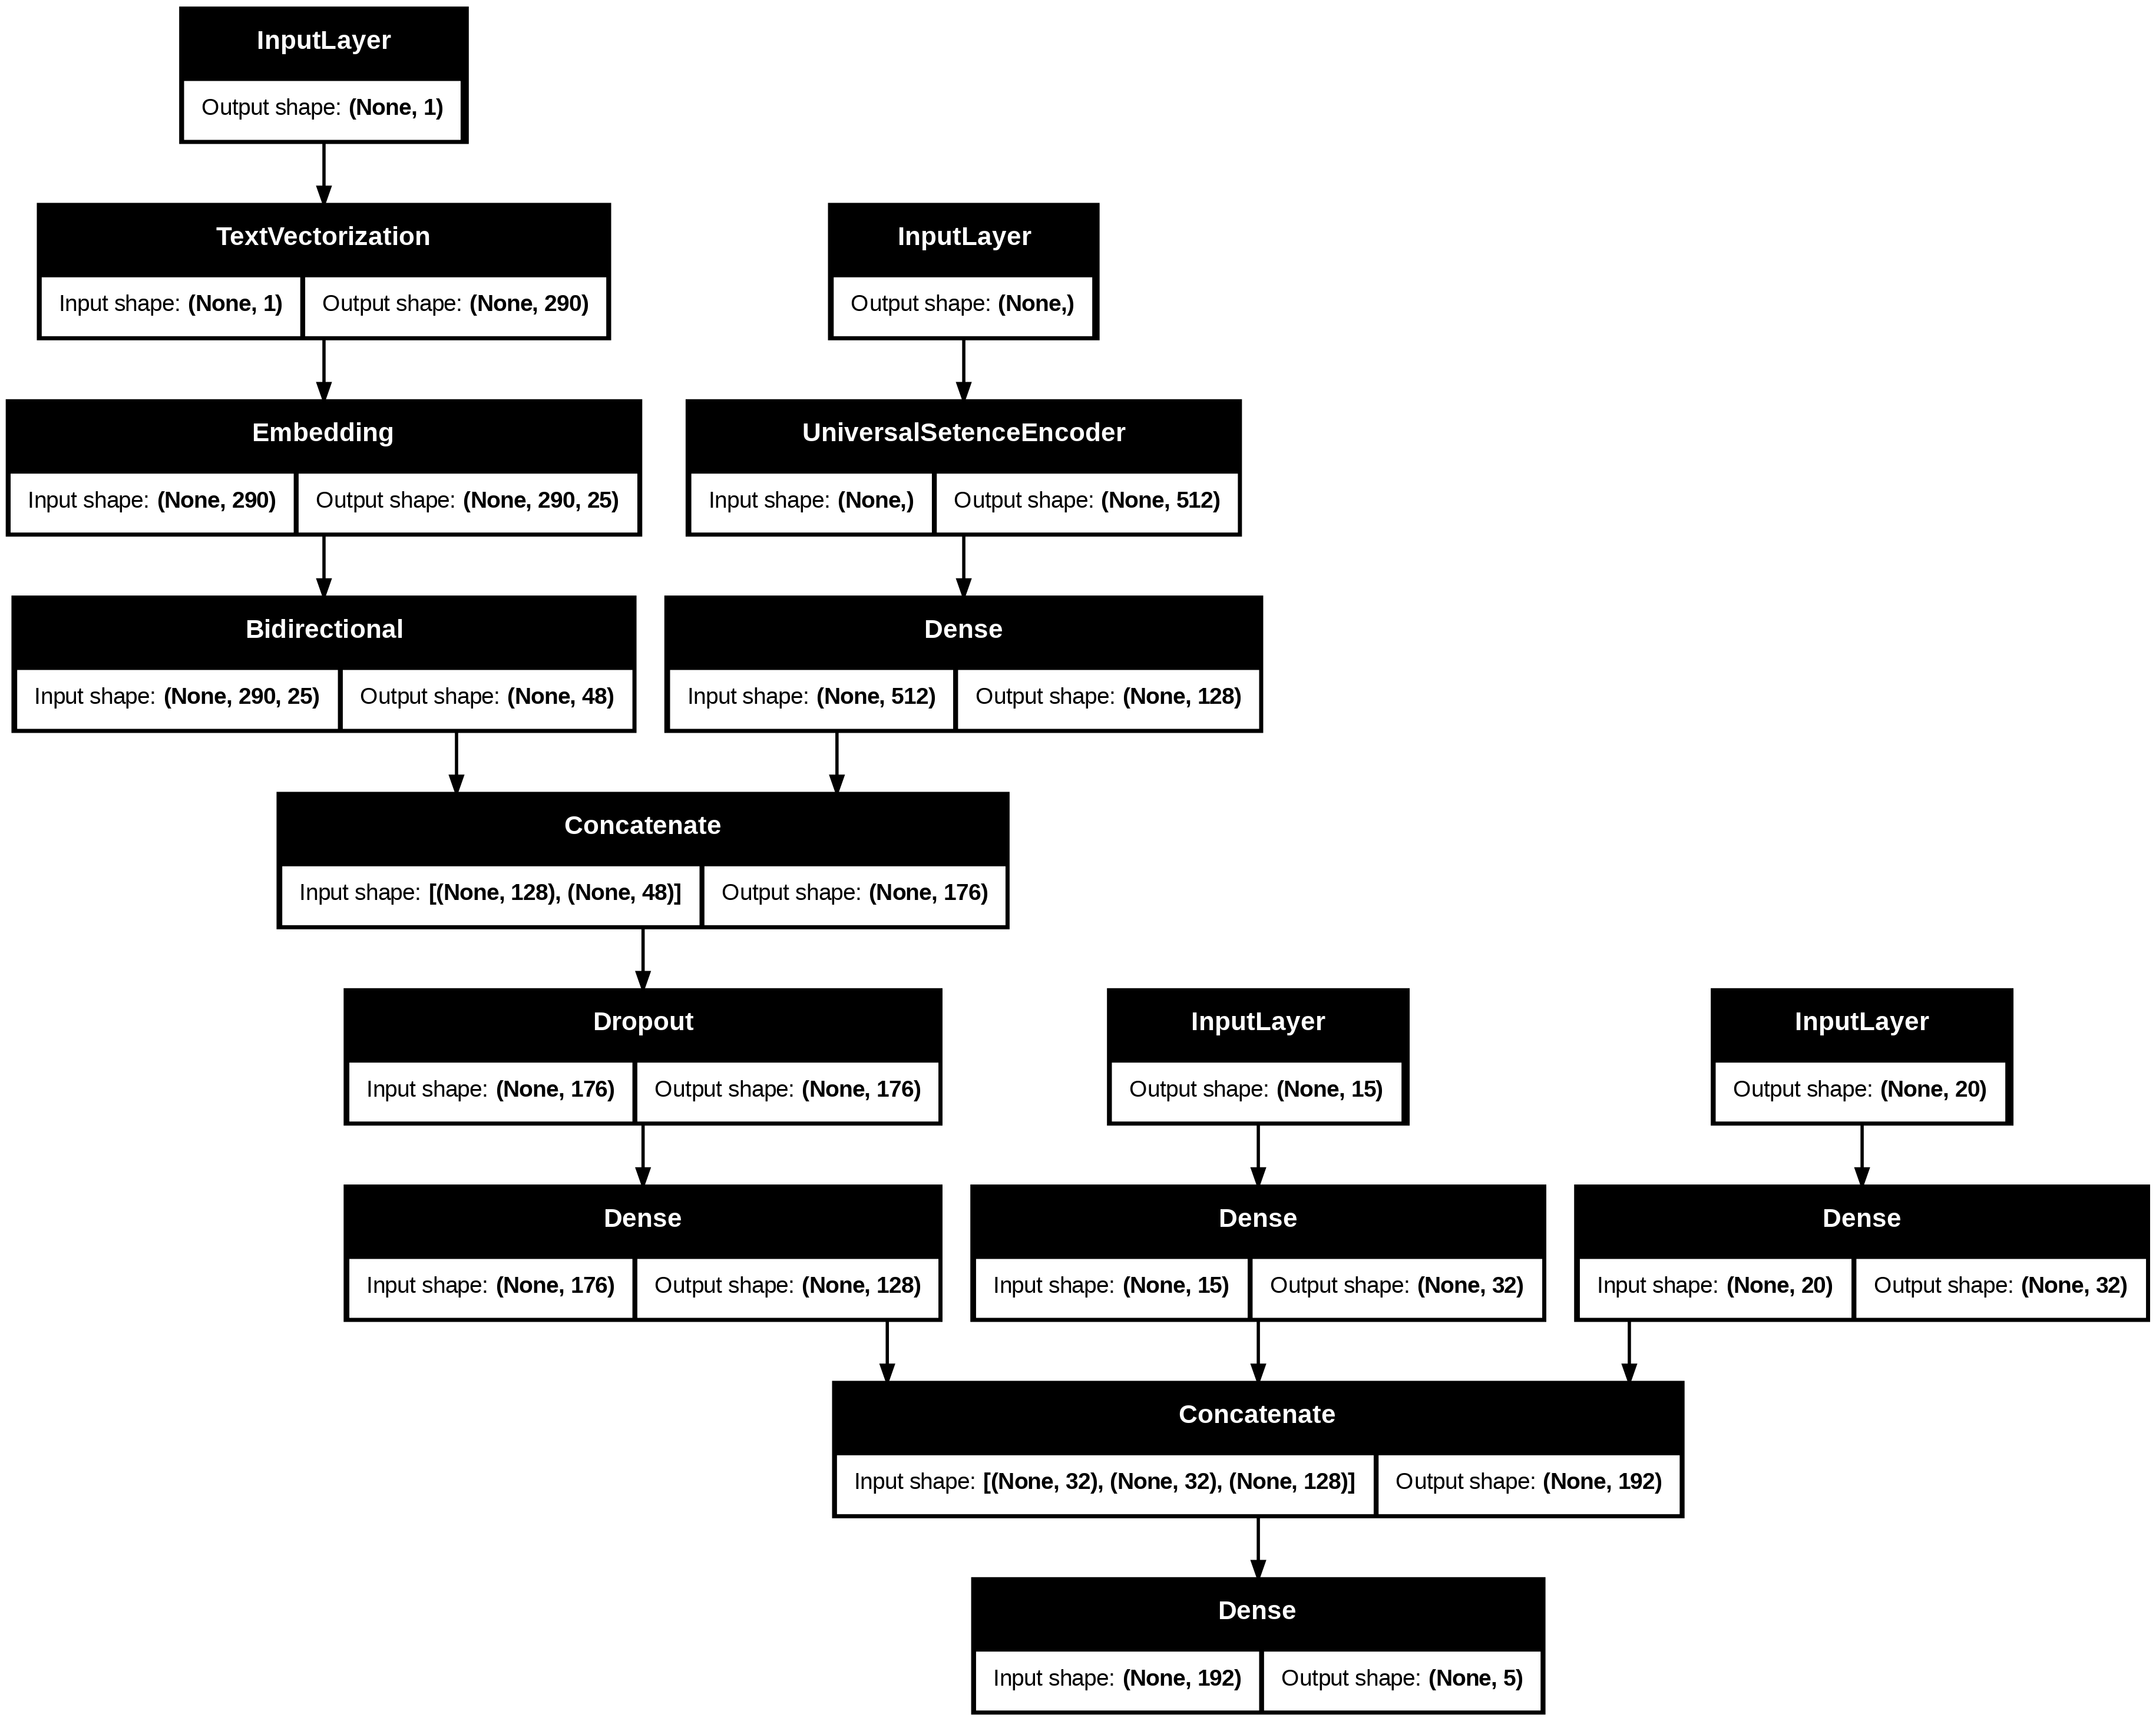

In [140]:
plot_model(model_5, show_shapes=True)

* Create tribrid embedding datasets using tf.Data

In [145]:
# Create efficient data pipepline
train_tribrid_data = tf.data.Dataset.from_tensor_slices(
    (train_sentences, train_chars, train_line_number_one_hot, train_total_line_one_hot)
)
train_tribrid_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_tribrid_dataset = tf.data.Dataset.zip(train_tribrid_data, train_tribrid_labels) # Concatenate data and labels
train_tribrid_dataset = train_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_tribrid_data = tf.data.Dataset.from_tensor_slices(
    (test_sentences, test_chars, test_line_number_one_hot, test_total_line_one_hot)
)
test_tribrid_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_tribrid_dataset = tf.data.Dataset.zip(test_tribrid_data, test_tribrid_labels) # Concatenate data and labels
test_tribrid_dataset = test_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_tribrid_data = tf.data.Dataset.from_tensor_slices(
    (val_sentences, valid_chars, valid_line_number_one_hot, valid_total_line_one_hot)
)
val_tribrid_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_tribrid_dataset = tf.data.Dataset.zip(val_tribrid_data, val_tribrid_labels) # Concatenate data and labels
val_tribrid_dataset = val_tribrid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [146]:
model_5_history = model_5.fit(
    train_tribrid_dataset, epochs = 3, validation_data = val_tribrid_dataset,
    callbacks = [
        create_tensorboard_callback("Experiments", "Tribrid_model")
    ]
)

Saving TensorBoard log files to: Experiments/Tribrid_model/20240824-062153
Epoch 1/3
Tensor("functional_29_1/USEEncoder_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
Tensor("functional_29_1/USEEncoder_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
5626/5627 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7705 - loss: 1.0256Tensor("functional_29_1/USEEncoder_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 224s 39ms/step - accuracy: 0.7705 - loss: 1.0256 - val_accuracy: 0.8436 - val_loss: 0.9132
Epoch 2/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 257s 38ms/step - accuracy: 0.8387 - loss: 0.9272 - val_accuracy: 0.8513 - val_loss: 0.9019
Epoch 3/3
5627/5627 ━━━━━━━━━━━━━━━━━━━━ 261s 38ms/step - accuracy: 0.8466 - loss: 0.9167 - val_accuracy: 0.8522 - val_loss: 0.9001


In [147]:
model_5_pred_probs = model_5.predict(val_tribrid_dataset)
model_5_pred = tf.argmax(model_5_pred_probs, axis=1)

Tensor("functional_29_1/USEEncoder_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
944/945 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/stepTensor("functional_29_1/USEEncoder_1/keras_layer_1/StatefulPartitionedCall:0", shape=(None, 512), dtype=float32)
945/945 ━━━━━━━━━━━━━━━━━━━━ 32s 32ms/step


In [148]:
model_5_results = calculate_results(val_labels_encoded, model_5_pred)
model_5_results

{'accuracy': 85.22441414007679,
 'precision': 0.8547341550828075,
 'recall': 0.8522441414007679,
 'f1': 0.8489543014973687}